## In this Assignment We are going to perfrom time series forcasting on temperature using the Deep Neural Network on jena_climate_2009_2016 dataset

#### Importing the required module for our Assignment

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import os
import sys
from math import ceil,floor

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import load_model

#### Loading the Data Set from tf-keras-dataset which is hosted on google cloud storage on which we will perform our timeseries forcasting using DNN

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

In [5]:
zip_path

'C:\\Users\\zidan\\.keras\\datasets\\jena_climate_2009_2016.csv.zip'

In [6]:
csv_path, _ = os.path.splitext(zip_path)

In [7]:
df = pd.read_csv(csv_path)

In [8]:
len(df)

420551

In [9]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


##### Our timeseries dataset is of 10 min interval but we want to do our analysis on hourly interval. So we will fetch hourly interval values from our dataframe 

In [11]:
# making the data hourly
df = df[5::6] # 5th index has 1st hour reading so starting from there then every 6th index will be the next hour reading therefore setting step_size=6

In [12]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [13]:
len(df) # size of our dataset decreased from 420551 to 70091

70091

##### setting Date Time column as index and Dropping it as a column

In [14]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.drop('Date Time',axis=1,inplace=True)
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


##### We will only do our time series forcating on Temperature column

<Axes: xlabel='Date Time'>

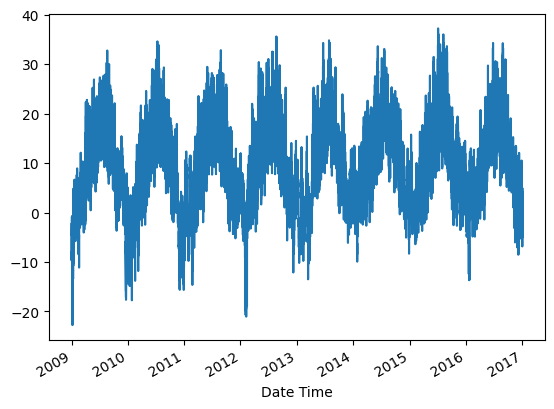

In [15]:
temp = df['T (degC)']
temp.plot()

In [16]:
temp_arr = temp.to_numpy()

##### Lets create Features and Label. We will use previous a window of size 'n' Which basically say how much values we need to look back to predict next value

In [17]:
from typing import Tuple 

In [18]:
def df_to_X_y(arr: [np.ndarray,pd.core.series.Series], window_size: int=5) -> Tuple[np.ndarray,np.ndarray]: 
    """Gets and transform the data into features and label based on window_size
    
    Args:
        arr (np.ndarray,pd.core.series.Series): data to be transformed into features and labels
        window_size (int): window_size say how much previous value to be dependent on for target 
            (default is 5)
    
    Returns:
        tupe: a tuple of features and label
    """
    if isinstance(arr,pd.core.series.Series):
        arr = arr.to_numpy()
    if not isinstance(arr,np.ndarray):
        raise TypeError(f'The input data need to be of Type {np.ndarray} or {pd.core.series.Series}')
    X = []
    y = []
    for i in range(len(arr)-window_size):
        #row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(arr[i:i+window_size])
        label = arr[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

### WINDOW SIZE = 5

In [19]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp_arr, WINDOW_SIZE)
X1.shape, y1.shape

((70086, 5), (70086,))

##### Splitting our dataset into Train,Test and Validation split

In [20]:
X_train1, y_train1 = X1[:60000], y1[:60000]
X_val1, y_val1 = X1[60000:65000], y1[60000:65000]
X_test1, y_test1 = X1[65000:], y1[65000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((60000, 5), (60000,), (5000, 5), (5000,), (5086, 5), (5086,))

In [21]:
X_train1

array([[-8.05, -8.88, -8.81, -9.05, -9.63],
       [-8.88, -8.81, -9.05, -9.63, -9.67],
       [-8.81, -9.05, -9.63, -9.67, -9.17],
       ...,
       [ 2.02,  2.27,  4.71,  6.07,  9.88],
       [ 2.27,  4.71,  6.07,  9.88, 13.53],
       [ 4.71,  6.07,  9.88, 13.53, 15.43]])

##### Creating our Deep neural network model

In [22]:
tf.random.set_seed(42)

In [23]:
model1 = Sequential() # we will be using tenserflow sequential API for modelling

In [24]:
model1.add(tf.keras.Input(WINDOW_SIZE,1))  # Adding InputLayer for defining input size of our data.

In [25]:
# Adding Dense Layer where unit/neuron are window_size*10 and activation function is relu for non-linearity
model1.add(Dense(WINDOW_SIZE*10,activation='relu')) 
# model1.add(Dropout(0.2))

In [26]:
# Adding Dense Layer where unit/neuron are window_size*6 and activation function is relu for non-linearity
model1.add(Dense(WINDOW_SIZE*6,activation='relu'))
# model1.add(Dropout(0.2))

In [27]:
# Adding Dense Layer where unit/neuron are window_size*3 and activation function is relu for non-linearity
model1.add(Dense(WINDOW_SIZE*3,activation='relu'))
# model1.add(Dropout(0.05))

In [28]:
# Adding Dense Layer where unit/neuron are window_size and activation function is relu for non-linearity
model1.add(Dense(WINDOW_SIZE,activation='relu'))
# model1.add(Dropout(0.2))

In [29]:
# Adding Dense Layer where unit/neuron are 1 which is basically our output layer and activation function is linear because we want our target to be continuous
model1.add(Dense(1,activation='linear'))

In [30]:
model1.summary() # checking the summary of our sequential model like how much param it train on each layer etc

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 50)                   300       
                                                                 
 dense_1 (Dense)             (1, 30)                   1530      
                                                                 
 dense_2 (Dense)             (1, 15)                   465       
                                                                 
 dense_3 (Dense)             (1, 5)                    80        
                                                                 
 dense_4 (Dense)             (1, 1)                    6         
                                                                 
Total params: 2381 (9.30 KB)
Trainable params: 2381 (9.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# if loss is no longer decreasing considering min_delta and patience
patience = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [32]:
cp1 = ModelCheckpoint('models/temperature_forcast/model1', save_best_only=True)  # for saving our model to a location for future use. So we don't need to train model again
# `save_best_only=True`, it only saves when the model is considered the "best"

In [33]:
logdir = 'logs/temperature_forcast/model1'

In [34]:
tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=logdir) # Enable visualizations for TensorBoard.
# can read more about this on :- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
# for launching tensorboad using cli if install tensorflow using pip :- tensorboard --logdir=path_to_your_logs

In [35]:
# Configures the model for training. like we can configure loss,optimizer,metrics
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate = 0.001), metrics=[RootMeanSquaredError()])

In [36]:
"""
Trains the model for a fixed number of epochs (dataset iterations).
Can configure number of epochs,callbacks,pass validation date,pass batch_size for running in batches.
Storing the call in hist so we can use the matrix for future analysis in our case it will store:-
['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error']
"""
hist1 = model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp1,tensorboard_callback1,patience])

Epoch 1/100
1861/1875 [============================>.] - ETA: 0s - loss: 5.2202 - root_mean_squared_error: 2.2848INFO:tensorflow:Assets written to: models/temperature_forcast\model1\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model1\assets


1875/1875 [==============================] - 3s 1ms/step - loss: 5.1865 - root_mean_squared_error: 2.2774 - val_loss: 0.5621 - val_root_mean_squared_error: 0.7497
Epoch 2/100
1819/1875 [============================>.] - ETA: 0s - loss: 0.7292 - root_mean_squared_error: 0.8539INFO:tensorflow:Assets written to: models/temperature_forcast\model1\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model1\assets


1875/1875 [==============================] - 3s 1ms/step - loss: 0.7255 - root_mean_squared_error: 0.8517 - val_loss: 0.4986 - val_root_mean_squared_error: 0.7061
Epoch 3/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.7021 - root_mean_squared_error: 0.8379 - val_loss: 0.5238 - val_root_mean_squared_error: 0.7237
Epoch 4/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6973 - root_mean_squared_error: 0.8351 - val_loss: 0.5370 - val_root_mean_squared_error: 0.7328
Epoch 5/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6850 - root_mean_squared_error: 0.8277 - val_loss: 0.5396 - val_root_mean_squared_error: 0.7346
Epoch 6/100
1861/1875 [============================>.] - ETA: 0s - loss: 0.6811 - root_mean_squared_error: 0.8253INFO:tensorflow:Assets written to: models/temperature_forcast\model1\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model1\assets


1875/1875 [==============================] - 3s 1ms/step - loss: 0.6807 - root_mean_squared_error: 0.8251 - val_loss: 0.4906 - val_root_mean_squared_error: 0.7005
Epoch 7/100
1872/1875 [============================>.] - ETA: 0s - loss: 0.6671 - root_mean_squared_error: 0.8167INFO:tensorflow:Assets written to: models/temperature_forcast\model1\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model1\assets


1875/1875 [==============================] - 2s 1ms/step - loss: 0.6671 - root_mean_squared_error: 0.8168 - val_loss: 0.4902 - val_root_mean_squared_error: 0.7001
Epoch 8/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6720 - root_mean_squared_error: 0.8198 - val_loss: 0.5340 - val_root_mean_squared_error: 0.7308
Epoch 9/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6652 - root_mean_squared_error: 0.8156 - val_loss: 0.5216 - val_root_mean_squared_error: 0.7222
Epoch 10/100
1875/1875 [==============================] - 2s 989us/step - loss: 0.6667 - root_mean_squared_error: 0.8165 - val_loss: 0.5277 - val_root_mean_squared_error: 0.7265
Epoch 11/100
1875/1875 [==============================] - 2s 998us/step - loss: 0.6664 - root_mean_squared_error: 0.8163 - val_loss: 0.5978 - val_root_mean_squared_error: 0.7732
Epoch 12/100
1852/1875 [============================>.] - ETA: 0s - loss: 0.6626 - root_mean_squared_error: 0.8140INFO:tensorflow:A

INFO:tensorflow:Assets written to: models/temperature_forcast\model1\assets


1875/1875 [==============================] - 2s 1ms/step - loss: 0.6618 - root_mean_squared_error: 0.8135 - val_loss: 0.4765 - val_root_mean_squared_error: 0.6903
Epoch 13/100
1830/1875 [============================>.] - ETA: 0s - loss: 0.6621 - root_mean_squared_error: 0.8137INFO:tensorflow:Assets written to: models/temperature_forcast\model1\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model1\assets


1875/1875 [==============================] - 2s 1ms/step - loss: 0.6614 - root_mean_squared_error: 0.8133 - val_loss: 0.4757 - val_root_mean_squared_error: 0.6897
Epoch 14/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6546 - root_mean_squared_error: 0.8091 - val_loss: 0.4968 - val_root_mean_squared_error: 0.7048
Epoch 15/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6544 - root_mean_squared_error: 0.8089 - val_loss: 0.4853 - val_root_mean_squared_error: 0.6966
Epoch 16/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6579 - root_mean_squared_error: 0.8111 - val_loss: 0.4869 - val_root_mean_squared_error: 0.6978
Epoch 17/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6497 - root_mean_squared_error: 0.8060 - val_loss: 0.4904 - val_root_mean_squared_error: 0.7003
Epoch 18/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6535 - root_mean_squared_error: 0.8084 - val_loss: 0.

In [37]:
hist1.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

#### Plot Performance

##### MSE LOSS PLOT

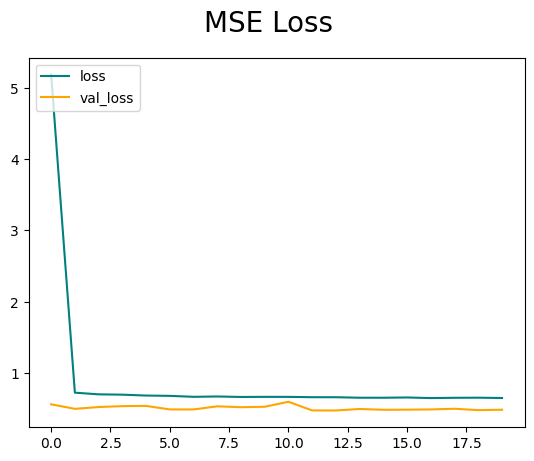

In [38]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist1.history['loss'], color='teal', label='loss')
plt.plot(hist1.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('MSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##### RMSE LOSS PLOT

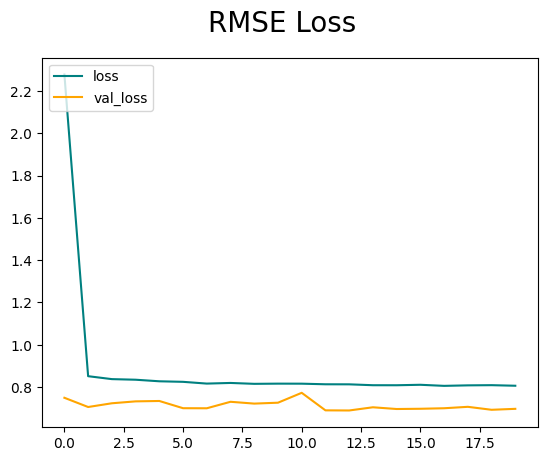

In [39]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist1.history['root_mean_squared_error'], color='teal', label='loss')
plt.plot(hist1.history['val_root_mean_squared_error'], color='orange', label='val_loss')
fig.suptitle('RMSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [40]:
# loading the model
model1 = load_model('models/temperature_forcast/model1/')

In [41]:
# predicting train dataset on loaded model
train_predictions1 = model1.predict(X_train1).flatten()
# storing predicted and actual in a dataframe
train_results1 = pd.DataFrame(data={'Train Predictions':train_predictions1, 'Actuals':y_train1})
train_results1.head()

1875/1875 [==============================] - 1s 653us/step


,Train Predictions,Actuals
0,-9.717002,-9.67
1,-9.649807,-9.17
2,-8.750425,-8.10
3,-7.134214,-7.66
4,-6.966152,-7.04


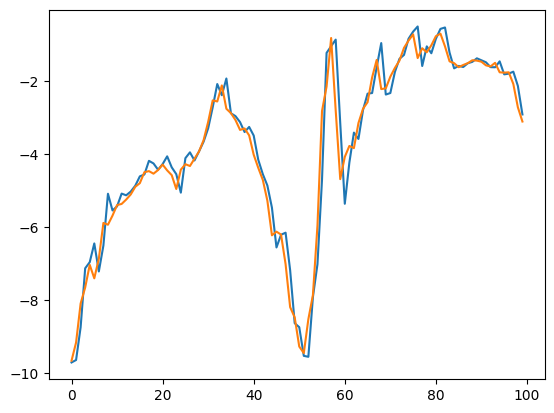

In [42]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(train_results1['Train Predictions'][:100])
plt.plot(train_results1['Actuals'][:100])

In [43]:
# predicting validation dataset on loaded model
val_predictions1 = model1.predict(X_val1).flatten()
# storing predicted and actual in a dataframe
val_results1 = pd.DataFrame(data={'Val Predictions':val_predictions1, 'Actuals':y_val1})
val_results1.head()

157/157 [==============================] - 0s 758us/step


,Val Predictions,Actuals
0,15.565946,14.02
1,13.367970,13.67
2,12.903316,12.27
3,11.399966,11.19
4,10.475335,10.85


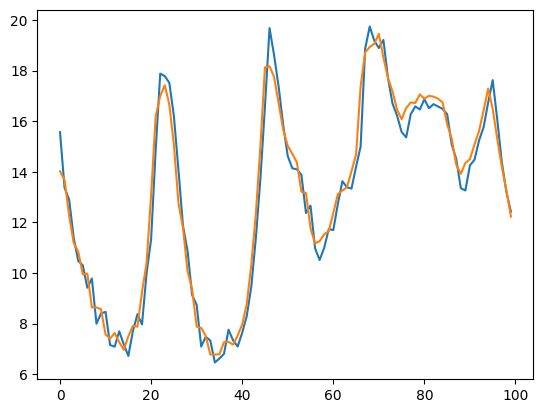

In [44]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(val_results1['Val Predictions'][:100])
plt.plot(val_results1['Actuals'][:100])

In [45]:
# predicting validation dataset on loaded model
test_predictions1 = model1.predict(X_test1).flatten()
# storing predicted and actual in a dataframe
test_results1 = pd.DataFrame(data={'Test Predictions':test_predictions1, 'Actuals':y_test1})
test_results1.head()

159/159 [==============================] - 0s 731us/step


,Test Predictions,Actuals
0,14.186225,13.99
1,13.092107,13.46
2,12.700976,12.93
3,12.307904,12.43
4,11.898788,12.17


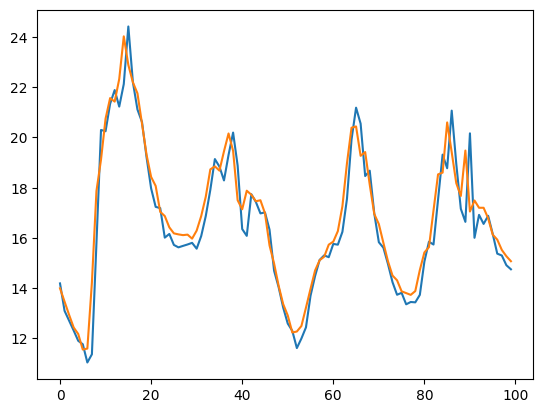

In [46]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(test_results1['Test Predictions'][:100])
plt.plot(test_results1['Actuals'][:100])

### WINDOW SIZE = 10

In [47]:
WINDOW_SIZE = 10
X2, y2 = df_to_X_y(temp_arr, WINDOW_SIZE)
X2.shape, y2.shape

((70081, 10), (70081,))

##### Splitting our dataset into Train,Test and Validation split

In [48]:
X_train2, y_train2 = X2[:60000], y2[:60000]
X_val2, y_val2 = X2[60000:65000], y2[60000:65000]
X_test2, y_test2 = X2[65000:], y2[65000:]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((60000, 10), (60000,), (5000, 10), (5000,), (5081, 10), (5081,))

In [49]:
X_train2

array([[-8.05, -8.88, -8.81, ..., -8.1 , -7.66, -7.04],
       [-8.88, -8.81, -9.05, ..., -7.66, -7.04, -7.41],
       [-8.81, -9.05, -9.63, ..., -7.04, -7.41, -6.87],
       ...,
       [ 2.02,  2.27,  4.71, ..., 15.54, 14.02, 13.67],
       [ 2.27,  4.71,  6.07, ..., 14.02, 13.67, 12.27],
       [ 4.71,  6.07,  9.88, ..., 13.67, 12.27, 11.19]])

##### Creating our Deep neural network model

In [50]:
tf.random.set_seed(42)

In [51]:
model2 = Sequential() # we will be using tenserflow sequential API for modelling

In [52]:
model2.add(tf.keras.Input(WINDOW_SIZE,1))  # Adding InputLayer for defining input size of our data.

In [53]:
# Adding Dense Layer where unit/neuron are window_size*10 and activation function is relu for non-linearity
model2.add(Dense(WINDOW_SIZE*10,activation='relu')) 
# model2.add(Dropout(0.2))

In [54]:
# Adding Dense Layer where unit/neuron are window_size*6 and activation function is relu for non-linearity
model2.add(Dense(WINDOW_SIZE*6,activation='relu'))
# model2.add(Dropout(0.2))

In [55]:
# Adding Dense Layer where unit/neuron are window_size*3 and activation function is relu for non-linearity
model2.add(Dense(WINDOW_SIZE*3,activation='relu'))
# model2.add(Dropout(0.05))

In [56]:
# Adding Dense Layer where unit/neuron are window_size and activation function is relu for non-linearity
model2.add(Dense(WINDOW_SIZE,activation='relu'))
# model2.add(Dropout(0.2))

In [57]:
# Adding Dense Layer where unit/neuron are 1 which is basically our output layer and activation function is linear because we want our target to be continuous
model2.add(Dense(1,activation='linear'))

In [58]:
model2.summary() # checking the summary of our sequential model like how much param it train on each layer etc

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (1, 100)                  1100      
                                                                 
 dense_6 (Dense)             (1, 60)                   6060      
                                                                 
 dense_7 (Dense)             (1, 30)                   1830      
                                                                 
 dense_8 (Dense)             (1, 10)                   310       
                                                                 
 dense_9 (Dense)             (1, 1)                    11        
                                                                 
Total params: 9311 (36.37 KB)
Trainable params: 9311 (36.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
# if loss is no longer decreasing considering min_delta and patience
patience = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [60]:
cp2 = ModelCheckpoint('models/temperature_forcast/model2', save_best_only=True)  # for saving our model to a location for future use. So we don't need to train model again
# `save_best_only=True`, it only saves when the model is considered the "best"

In [61]:
logdir = 'logs/temperature_forcast/model2'

In [62]:
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(log_dir=logdir) # Enable visualizations for TensorBoard.
# can read more about this on :- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
# for launching tensorboad using cli if install tensorflow using pip :- tensorboard --logdir=path_to_your_logs

In [63]:
# Configures the model for training. like we can configure loss,optimizer,metrics
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate = 0.001), metrics=[RootMeanSquaredError()])

In [64]:
"""
Trains the model for a fixed number of epochs (dataset iterations).
Can configure number of epochs,callbacks,pass validation date,pass batch_size for running in batches.
Storing the call in hist so we can use the matrix for future analysis in our case it will store:-
['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error']
"""
hist2 = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[cp2,tensorboard_callback2,patience])

Epoch 1/100
1834/1875 [============================>.] - ETA: 0s - loss: 2.6371 - root_mean_squared_error: 1.6239INFO:tensorflow:Assets written to: models/temperature_forcast\model2\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model2\assets


1875/1875 [==============================] - 3s 1ms/step - loss: 2.5973 - root_mean_squared_error: 1.6116 - val_loss: 0.4930 - val_root_mean_squared_error: 0.7022
Epoch 2/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.7207 - root_mean_squared_error: 0.8490 - val_loss: 0.5125 - val_root_mean_squared_error: 0.7159
Epoch 3/100
1843/1875 [============================>.] - ETA: 0s - loss: 0.6880 - root_mean_squared_error: 0.8295INFO:tensorflow:Assets written to: models/temperature_forcast\model2\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model2\assets


1875/1875 [==============================] - 2s 1ms/step - loss: 0.6867 - root_mean_squared_error: 0.8287 - val_loss: 0.4929 - val_root_mean_squared_error: 0.7021
Epoch 4/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6947 - root_mean_squared_error: 0.8335 - val_loss: 0.6669 - val_root_mean_squared_error: 0.8166
Epoch 5/100
1851/1875 [============================>.] - ETA: 0s - loss: 0.6788 - root_mean_squared_error: 0.8239INFO:tensorflow:Assets written to: models/temperature_forcast\model2\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model2\assets


1875/1875 [==============================] - 3s 1ms/step - loss: 0.6791 - root_mean_squared_error: 0.8241 - val_loss: 0.4804 - val_root_mean_squared_error: 0.6931
Epoch 6/100
1833/1875 [============================>.] - ETA: 0s - loss: 0.6628 - root_mean_squared_error: 0.8141INFO:tensorflow:Assets written to: models/temperature_forcast\model2\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model2\assets


1875/1875 [==============================] - 2s 1ms/step - loss: 0.6633 - root_mean_squared_error: 0.8144 - val_loss: 0.4749 - val_root_mean_squared_error: 0.6891
Epoch 7/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6678 - root_mean_squared_error: 0.8172 - val_loss: 0.5260 - val_root_mean_squared_error: 0.7253
Epoch 8/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6581 - root_mean_squared_error: 0.8112 - val_loss: 0.4778 - val_root_mean_squared_error: 0.6913
Epoch 9/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6518 - root_mean_squared_error: 0.8073 - val_loss: 0.4771 - val_root_mean_squared_error: 0.6907
Epoch 10/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6501 - root_mean_squared_error: 0.8063 - val_loss: 0.4885 - val_root_mean_squared_error: 0.6989
Epoch 11/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6487 - root_mean_squared_error: 0.8054 - val_loss: 0.506

INFO:tensorflow:Assets written to: models/temperature_forcast\model2\assets


1875/1875 [==============================] - 2s 1ms/step - loss: 0.6384 - root_mean_squared_error: 0.7990 - val_loss: 0.4724 - val_root_mean_squared_error: 0.6873
Epoch 14/100
1830/1875 [============================>.] - ETA: 0s - loss: 0.6334 - root_mean_squared_error: 0.7959INFO:tensorflow:Assets written to: models/temperature_forcast\model2\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model2\assets


1875/1875 [==============================] - 2s 1ms/step - loss: 0.6319 - root_mean_squared_error: 0.7949 - val_loss: 0.4687 - val_root_mean_squared_error: 0.6846
Epoch 15/100
1865/1875 [============================>.] - ETA: 0s - loss: 0.6301 - root_mean_squared_error: 0.7938INFO:tensorflow:Assets written to: models/temperature_forcast\model2\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model2\assets


1875/1875 [==============================] - 3s 1ms/step - loss: 0.6298 - root_mean_squared_error: 0.7936 - val_loss: 0.4666 - val_root_mean_squared_error: 0.6831
Epoch 16/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6356 - root_mean_squared_error: 0.7972 - val_loss: 0.4678 - val_root_mean_squared_error: 0.6840
Epoch 17/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6270 - root_mean_squared_error: 0.7918 - val_loss: 0.4675 - val_root_mean_squared_error: 0.6838
Epoch 18/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6284 - root_mean_squared_error: 0.7927 - val_loss: 0.4868 - val_root_mean_squared_error: 0.6977
Epoch 19/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6254 - root_mean_squared_error: 0.7908 - val_loss: 0.4922 - val_root_mean_squared_error: 0.7015
Epoch 20/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6187 - root_mean_squared_error: 0.7866 - val_loss: 0.

INFO:tensorflow:Assets written to: models/temperature_forcast\model2\assets


1875/1875 [==============================] - 3s 1ms/step - loss: 0.6184 - root_mean_squared_error: 0.7864 - val_loss: 0.4606 - val_root_mean_squared_error: 0.6787
Epoch 23/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6145 - root_mean_squared_error: 0.7839 - val_loss: 0.4733 - val_root_mean_squared_error: 0.6879
Epoch 24/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6129 - root_mean_squared_error: 0.7829 - val_loss: 0.4980 - val_root_mean_squared_error: 0.7057
Epoch 25/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6120 - root_mean_squared_error: 0.7823 - val_loss: 0.4629 - val_root_mean_squared_error: 0.6803
Epoch 26/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6160 - root_mean_squared_error: 0.7849 - val_loss: 0.4823 - val_root_mean_squared_error: 0.6945
Epoch 27/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6131 - root_mean_squared_error: 0.7830 - val_loss: 0.

In [65]:
hist2.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

#### Plot Performance

##### MSE LOSS PLOT

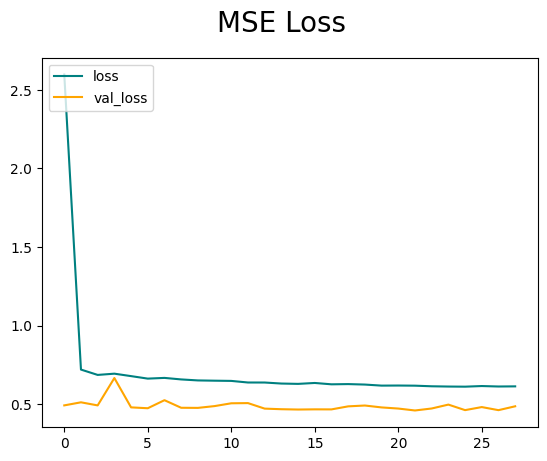

In [66]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist2.history['loss'], color='teal', label='loss')
plt.plot(hist2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('MSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##### RMSE LOSS PLOT

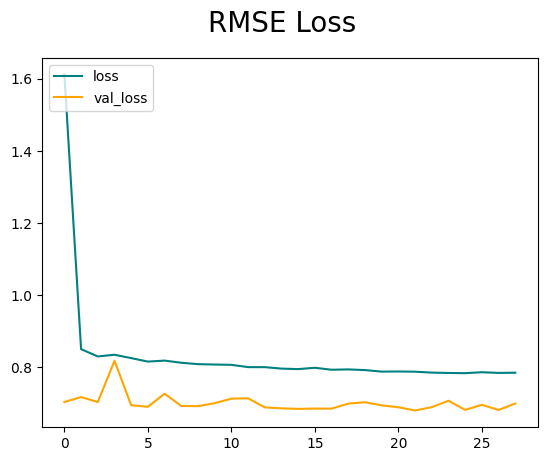

In [67]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist2.history['root_mean_squared_error'], color='teal', label='loss')
plt.plot(hist2.history['val_root_mean_squared_error'], color='orange', label='val_loss')
fig.suptitle('RMSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [68]:
# loading the model
model2 = load_model('models/temperature_forcast/model2/')

In [69]:
# predicting train dataset on loaded model
train_predictions2 = model2.predict(X_train2).flatten()
# storing predicted and actual in a dataframe
train_results2 = pd.DataFrame(data={'Train Predictions':train_predictions2, 'Actuals':y_train2})
train_results2.head()

1875/1875 [==============================] - 1s 659us/step


,Train Predictions,Actuals
0,-6.132734,-7.41
1,-7.054564,-6.87
2,-6.366725,-5.89
3,-4.989053,-5.94
4,-5.302051,-5.69


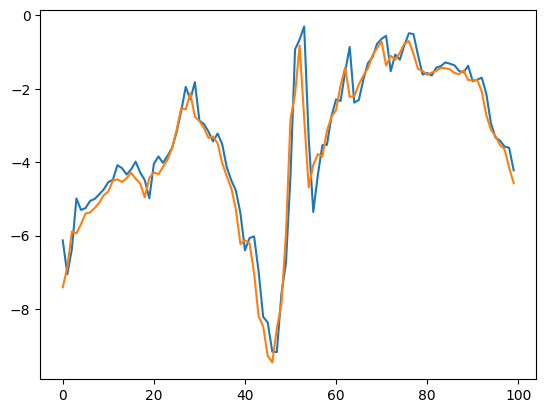

In [70]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(train_results2['Train Predictions'][:100])
plt.plot(train_results2['Actuals'][:100])

In [71]:
# predicting validation dataset on loaded model
val_predictions2 = model2.predict(X_val2).flatten()
# storing predicted and actual in a dataframe
val_results2 = pd.DataFrame(data={'Val Predictions':val_predictions2, 'Actuals':y_val2})
val_results2.head()

157/157 [==============================] - 0s 813us/step


,Val Predictions,Actuals
0,9.949205,9.95
1,9.018252,9.98
2,9.544835,8.64
3,8.128176,8.64
4,8.569903,8.57


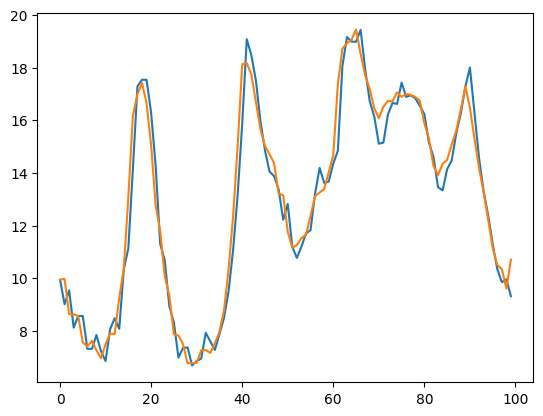

In [72]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(val_results2['Val Predictions'][:100])
plt.plot(val_results2['Actuals'][:100])

In [73]:
# predicting validation dataset on loaded model
test_predictions2 = model2.predict(X_test2).flatten()
# storing predicted and actual in a dataframe
test_results2 = pd.DataFrame(data={'Test Predictions':test_predictions2, 'Actuals':y_test2})
test_results2.head()

159/159 [==============================] - 0s 713us/step


,Test Predictions,Actuals
0,11.936902,11.55
1,11.326441,11.59
2,11.576592,14.22
3,16.075722,17.87
4,20.169682,19.12


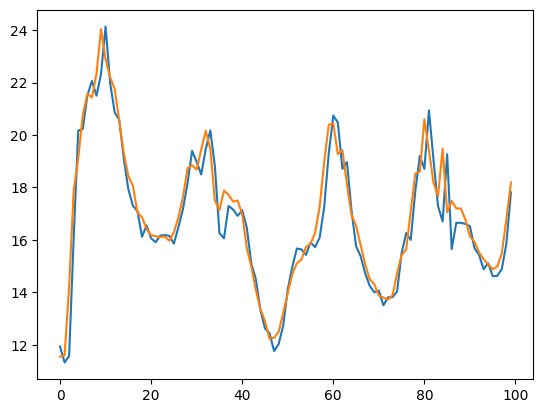

In [74]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(test_results2['Test Predictions'][:100])
plt.plot(test_results2['Actuals'][:100])

### WINDOW SIZE = 15

In [75]:
WINDOW_SIZE = 15
X3, y3 = df_to_X_y(temp_arr, WINDOW_SIZE)
X3.shape, y3.shape

((70076, 15), (70076,))

##### Splitting our dataset into Train,Test and Validation split

In [76]:
X_train3, y_train3 = X3[:60000], y3[:60000]
X_val3, y_val3 = X3[60000:65000], y3[60000:65000]
X_test3, y_test3 = X3[65000:], y3[65000:]
X_train3.shape, y_train3.shape, X_val3.shape, y_val3.shape, X_test3.shape, y_test3.shape

((60000, 15), (60000,), (5000, 15), (5000,), (5076, 15), (5076,))

In [77]:
X_train3

array([[-8.05, -8.88, -8.81, ..., -5.89, -5.94, -5.69],
       [-8.88, -8.81, -9.05, ..., -5.94, -5.69, -5.4 ],
       [-8.81, -9.05, -9.63, ..., -5.69, -5.4 , -5.37],
       ...,
       [ 2.02,  2.27,  4.71, ..., 10.85,  9.95,  9.98],
       [ 2.27,  4.71,  6.07, ...,  9.95,  9.98,  8.64],
       [ 4.71,  6.07,  9.88, ...,  9.98,  8.64,  8.64]])

##### Creating our Deep neural network model

In [78]:
tf.random.set_seed(42)

In [79]:
model3 = Sequential() # we will be using tenserflow sequential API for modelling

In [80]:
model3.add(tf.keras.Input(WINDOW_SIZE,1))  # Adding InputLayer for defining input size of our data.

In [81]:
# Adding Dense Layer where unit/neuron are window_size*10 and activation function is relu for non-linearity
model3.add(Dense(WINDOW_SIZE*10,activation='relu')) 
# model3.add(Dropout(0.2))

In [82]:
# Adding Dense Layer where unit/neuron are window_size*6 and activation function is relu for non-linearity
model3.add(Dense(WINDOW_SIZE*6,activation='relu'))
# model3.add(Dropout(0.2))

In [83]:
# Adding Dense Layer where unit/neuron are window_size*3 and activation function is relu for non-linearity
model3.add(Dense(WINDOW_SIZE*3,activation='relu'))
# model3.add(Dropout(0.05))

In [84]:
# Adding Dense Layer where unit/neuron are window_size and activation function is relu for non-linearity
model3.add(Dense(WINDOW_SIZE,activation='relu'))
# model3.add(Dropout(0.2))

In [85]:
# Adding Dense Layer where unit/neuron are 1 which is basically our output layer and activation function is linear because we want our target to be continuous
model3.add(Dense(1,activation='linear'))

In [86]:
model3.summary() # checking the summary of our sequential model like how much param it train on each layer etc

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (1, 150)                  2400      
                                                                 
 dense_11 (Dense)            (1, 90)                   13590     
                                                                 
 dense_12 (Dense)            (1, 45)                   4095      
                                                                 
 dense_13 (Dense)            (1, 15)                   690       
                                                                 
 dense_14 (Dense)            (1, 1)                    16        
                                                                 
Total params: 20791 (81.21 KB)
Trainable params: 20791 (81.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [87]:
# if loss is no longer decreasing considering min_delta and patience
patience = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [88]:
cp3 = ModelCheckpoint('models/temperature_forcast/model3', save_best_only=True)  # for saving our model to a location for future use. So we don't need to train model again
# `save_best_only=True`, it only saves when the model is considered the "best"

In [89]:
logdir = 'logs/temperature_forcast/model3'

In [90]:
tensorboard_callback3 = tf.keras.callbacks.TensorBoard(log_dir=logdir) # Enable visualizations for TensorBoard.
# can read more about this on :- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
# for launching tensorboad using cli if install tensorflow using pip :- tensorboard --logdir=path_to_your_logs

In [91]:
# Configures the model for training. like we can configure loss,optimizer,metrics
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate = 0.001), metrics=[RootMeanSquaredError()])

In [92]:
"""
Trains the model for a fixed number of epochs (dataset iterations).
Can configure number of epochs,callbacks,pass validation date,pass batch_size for running in batches.
Storing the call in hist so we can use the matrix for future analysis in our case it will store:-
['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error']
"""
hist3 = model3.fit(X_train3, y_train3, validation_data=(X_val3, y_val3), epochs=100, callbacks=[cp3,tensorboard_callback3,patience])

Epoch 1/100
1856/1875 [============================>.] - ETA: 0s - loss: 1.4138 - root_mean_squared_error: 1.1891INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


1875/1875 [==============================] - 5s 3ms/step - loss: 1.4068 - root_mean_squared_error: 1.1861 - val_loss: 0.5019 - val_root_mean_squared_error: 0.7084
Epoch 2/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.7049 - root_mean_squared_error: 0.8396 - val_loss: 0.5040 - val_root_mean_squared_error: 0.7099
Epoch 3/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6809 - root_mean_squared_error: 0.8252 - val_loss: 0.5142 - val_root_mean_squared_error: 0.7171
Epoch 4/100
1865/1875 [============================>.] - ETA: 0s - loss: 0.6668 - root_mean_squared_error: 0.8166INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


1875/1875 [==============================] - 4s 2ms/step - loss: 0.6667 - root_mean_squared_error: 0.8165 - val_loss: 0.4700 - val_root_mean_squared_error: 0.6856
Epoch 5/100
1871/1875 [============================>.] - ETA: 0s - loss: 0.6428 - root_mean_squared_error: 0.8017INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6428 - root_mean_squared_error: 0.8018 - val_loss: 0.4693 - val_root_mean_squared_error: 0.6850
Epoch 6/100
1861/1875 [============================>.] - ETA: 0s - loss: 0.6422 - root_mean_squared_error: 0.8014INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6427 - root_mean_squared_error: 0.8017 - val_loss: 0.4613 - val_root_mean_squared_error: 0.6792
Epoch 7/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6341 - root_mean_squared_error: 0.7963 - val_loss: 0.4662 - val_root_mean_squared_error: 0.6828
Epoch 8/100
1872/1875 [============================>.] - ETA: 0s - loss: 0.6297 - root_mean_squared_error: 0.7935INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


1875/1875 [==============================] - 3s 1ms/step - loss: 0.6294 - root_mean_squared_error: 0.7933 - val_loss: 0.4584 - val_root_mean_squared_error: 0.6771
Epoch 9/100
1845/1875 [============================>.] - ETA: 0s - loss: 0.6263 - root_mean_squared_error: 0.7914INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


1875/1875 [==============================] - 3s 1ms/step - loss: 0.6264 - root_mean_squared_error: 0.7915 - val_loss: 0.4583 - val_root_mean_squared_error: 0.6770
Epoch 10/100
1864/1875 [============================>.] - ETA: 0s - loss: 0.6227 - root_mean_squared_error: 0.7891INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


1875/1875 [==============================] - 3s 1ms/step - loss: 0.6225 - root_mean_squared_error: 0.7890 - val_loss: 0.4557 - val_root_mean_squared_error: 0.6750
Epoch 11/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6105 - root_mean_squared_error: 0.7813 - val_loss: 0.4580 - val_root_mean_squared_error: 0.6768
Epoch 12/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6120 - root_mean_squared_error: 0.7823 - val_loss: 0.5117 - val_root_mean_squared_error: 0.7153
Epoch 13/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6093 - root_mean_squared_error: 0.7806 - val_loss: 0.4678 - val_root_mean_squared_error: 0.6840
Epoch 14/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6115 - root_mean_squared_error: 0.7820 - val_loss: 0.4612 - val_root_mean_squared_error: 0.6791
Epoch 15/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6032 - root_mean_squared_error: 0.7766 - val_loss: 0.

INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


1875/1875 [==============================] - 4s 2ms/step - loss: 0.5961 - root_mean_squared_error: 0.7721 - val_loss: 0.4519 - val_root_mean_squared_error: 0.6722
Epoch 21/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5921 - root_mean_squared_error: 0.7695 - val_loss: 0.4836 - val_root_mean_squared_error: 0.6954
Epoch 22/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5919 - root_mean_squared_error: 0.7694 - val_loss: 0.4566 - val_root_mean_squared_error: 0.6757
Epoch 23/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5888 - root_mean_squared_error: 0.7674 - val_loss: 0.5435 - val_root_mean_squared_error: 0.7372
Epoch 24/100
1835/1875 [============================>.] - ETA: 0s - loss: 0.5863 - root_mean_squared_error: 0.7657INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


1875/1875 [==============================] - 3s 1ms/step - loss: 0.5862 - root_mean_squared_error: 0.7657 - val_loss: 0.4494 - val_root_mean_squared_error: 0.6704
Epoch 25/100
1856/1875 [============================>.] - ETA: 0s - loss: 0.5848 - root_mean_squared_error: 0.7647INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


1875/1875 [==============================] - 3s 1ms/step - loss: 0.5853 - root_mean_squared_error: 0.7650 - val_loss: 0.4473 - val_root_mean_squared_error: 0.6688
Epoch 26/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5877 - root_mean_squared_error: 0.7666 - val_loss: 0.4523 - val_root_mean_squared_error: 0.6725
Epoch 27/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5851 - root_mean_squared_error: 0.7649 - val_loss: 0.4486 - val_root_mean_squared_error: 0.6698
Epoch 28/100
1819/1875 [============================>.] - ETA: 0s - loss: 0.5895 - root_mean_squared_error: 0.7678INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


1875/1875 [==============================] - 3s 1ms/step - loss: 0.5873 - root_mean_squared_error: 0.7664 - val_loss: 0.4465 - val_root_mean_squared_error: 0.6682
Epoch 29/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5839 - root_mean_squared_error: 0.7641 - val_loss: 0.4510 - val_root_mean_squared_error: 0.6715
Epoch 30/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5813 - root_mean_squared_error: 0.7624 - val_loss: 0.4512 - val_root_mean_squared_error: 0.6717
Epoch 31/100
1857/1875 [============================>.] - ETA: 0s - loss: 0.5785 - root_mean_squared_error: 0.7606INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model3\assets


1875/1875 [==============================] - 3s 1ms/step - loss: 0.5779 - root_mean_squared_error: 0.7602 - val_loss: 0.4452 - val_root_mean_squared_error: 0.6672
Epoch 32/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5842 - root_mean_squared_error: 0.7643 - val_loss: 0.4776 - val_root_mean_squared_error: 0.6911
Epoch 33/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5765 - root_mean_squared_error: 0.7593 - val_loss: 0.4481 - val_root_mean_squared_error: 0.6694
Epoch 34/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5767 - root_mean_squared_error: 0.7594 - val_loss: 0.4711 - val_root_mean_squared_error: 0.6863
Epoch 35/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5787 - root_mean_squared_error: 0.7607 - val_loss: 0.4653 - val_root_mean_squared_error: 0.6821
Epoch 36/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5767 - root_mean_squared_error: 0.7594 - val_loss: 0.

In [93]:
hist3.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

#### Plot Performance

##### MSE LOSS PLOT

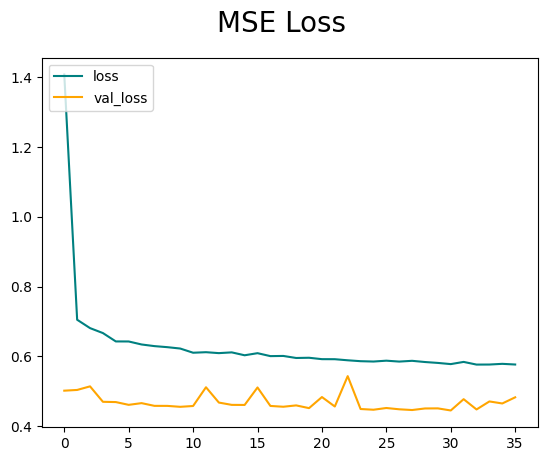

In [94]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist3.history['loss'], color='teal', label='loss')
plt.plot(hist3.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('MSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##### RMSE LOSS PLOT

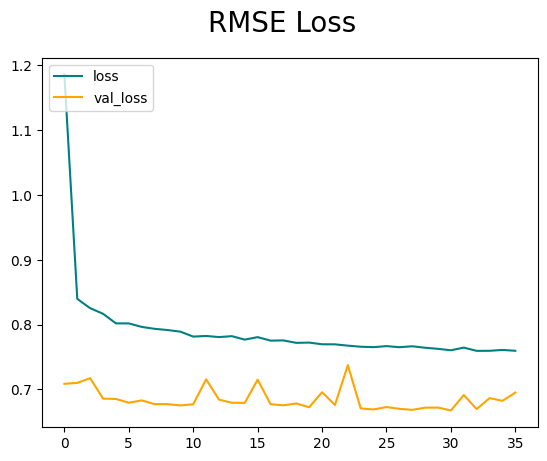

In [95]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist3.history['root_mean_squared_error'], color='teal', label='loss')
plt.plot(hist3.history['val_root_mean_squared_error'], color='orange', label='val_loss')
fig.suptitle('RMSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [96]:
# loading the model
model3 = load_model('models/temperature_forcast/model3/')

In [97]:
# predicting train dataset on loaded model
train_predictions3 = model3.predict(X_train3).flatten()
# storing predicted and actual in a dataframe
train_results3 = pd.DataFrame(data={'Train Predictions':train_predictions3, 'Actuals':y_train3})
train_results3.head()

1875/1875 [==============================] - 1s 679us/step


,Train Predictions,Actuals
0,-5.640495,-5.40
1,-5.362446,-5.37
2,-5.369148,-5.25
3,-5.244841,-5.11
4,-5.128849,-4.90


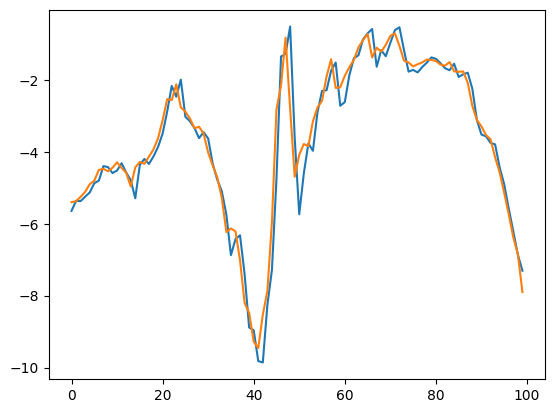

In [98]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(train_results3['Train Predictions'][:100])
plt.plot(train_results3['Actuals'][:100])

In [99]:
# predicting validation dataset on loaded model
val_predictions3 = model3.predict(X_val3).flatten()
# storing predicted and actual in a dataframe
val_results3 = pd.DataFrame(data={'Val Predictions':val_predictions3, 'Actuals':y_val3})
val_results3.head()

157/157 [==============================] - 0s 815us/step


,Val Predictions,Actuals
0,8.078488,7.57
1,7.076020,7.41
2,7.432577,7.63
3,8.261126,7.27
4,7.786891,6.97


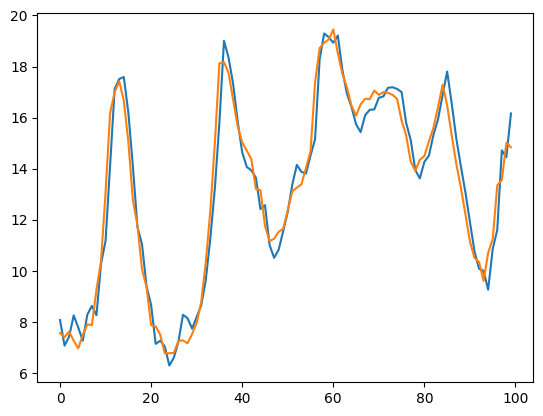

In [100]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(val_results3['Val Predictions'][:100])
plt.plot(val_results3['Actuals'][:100])

In [101]:
# predicting validation dataset on loaded model
test_predictions3 = model3.predict(X_test3).flatten()
# storing predicted and actual in a dataframe
test_results3 = pd.DataFrame(data={'Test Predictions':test_predictions3, 'Actuals':y_test3})
test_results3.head()

159/159 [==============================] - 0s 709us/step


,Test Predictions,Actuals
0,20.453323,20.75
1,21.715422,21.57
2,22.066391,21.43
3,21.484669,22.33
4,22.517111,24.03


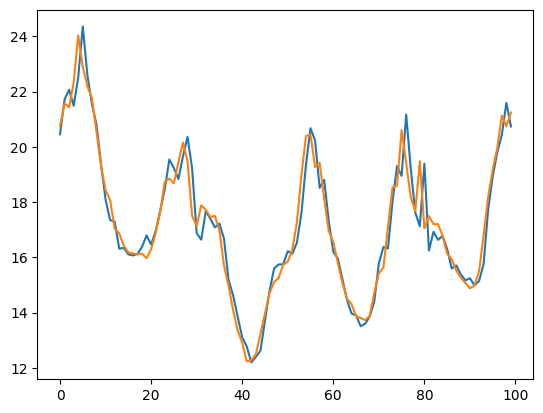

In [102]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(test_results3['Test Predictions'][:100])
plt.plot(test_results3['Actuals'][:100])

### WINDOW SIZE = 20

In [103]:
WINDOW_SIZE = 20
X4, y4 = df_to_X_y(temp_arr, WINDOW_SIZE)
X4.shape, y4.shape

((70071, 20), (70071,))

##### Splitting our dataset into Train,Test and Validation split

In [104]:
X_train4, y_train4 = X4[:60000], y4[:60000]
X_val4, y_val4 = X4[60000:65000], y4[60000:65000]
X_test4, y_test4 = X4[65000:], y4[65000:]
X_train4.shape, y_train4.shape, X_val4.shape, y_val4.shape, X_test4.shape, y_test4.shape

((60000, 20), (60000,), (5000, 20), (5000,), (5071, 20), (5071,))

In [105]:
X_train4

array([[-8.05, -8.88, -8.81, ..., -5.25, -5.11, -4.9 ],
       [-8.88, -8.81, -9.05, ..., -5.11, -4.9 , -4.8 ],
       [-8.81, -9.05, -9.63, ..., -4.9 , -4.8 , -4.5 ],
       ...,
       [ 2.02,  2.27,  4.71, ...,  8.57,  7.57,  7.41],
       [ 2.27,  4.71,  6.07, ...,  7.57,  7.41,  7.63],
       [ 4.71,  6.07,  9.88, ...,  7.41,  7.63,  7.27]])

##### Creating our Deep neural network model

In [106]:
tf.random.set_seed(42)

In [107]:
model4 = Sequential() # we will be using tenserflow sequential API for modelling

In [108]:
model4.add(tf.keras.Input(WINDOW_SIZE,1))  # Adding InputLayer for defining input size of our data.

In [109]:
# Adding Dense Layer where unit/neuron are window_size*10 and activation function is relu for non-linearity
model4.add(Dense(WINDOW_SIZE*10,activation='relu')) 
# model4.add(Dropout(0.2))

In [110]:
# Adding Dense Layer where unit/neuron are window_size*6 and activation function is relu for non-linearity
model4.add(Dense(WINDOW_SIZE*6,activation='relu'))
# model4.add(Dropout(0.2))

In [111]:
# Adding Dense Layer where unit/neuron are window_size*3 and activation function is relu for non-linearity
model4.add(Dense(WINDOW_SIZE*3,activation='relu'))
# model4.add(Dropout(0.05))

In [112]:
# Adding Dense Layer where unit/neuron are window_size and activation function is relu for non-linearity
model4.add(Dense(WINDOW_SIZE,activation='relu'))
# model4.add(Dropout(0.2))

In [113]:
# Adding Dense Layer where unit/neuron are 1 which is basically our output layer and activation function is linear because we want our target to be continuous
model4.add(Dense(1,activation='linear'))

In [114]:
model4.summary() # checking the summary of our sequential model like how much param it train on each layer etc

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (1, 200)                  4200      
                                                                 
 dense_16 (Dense)            (1, 120)                  24120     
                                                                 
 dense_17 (Dense)            (1, 60)                   7260      
                                                                 
 dense_18 (Dense)            (1, 20)                   1220      
                                                                 
 dense_19 (Dense)            (1, 1)                    21        
                                                                 
Total params: 36821 (143.83 KB)
Trainable params: 36821 (143.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [115]:
# if loss is no longer decreasing considering min_delta and patience
patience = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [116]:
cp4 = ModelCheckpoint('models/temperature_forcast/model4', save_best_only=True)  # for saving our model to a location for future use. So we don't need to train model again
# `save_best_only=True`, it only saves when the model is considered the "best"

In [117]:
logdir = 'logs/temperature_forcast/model4'

In [118]:
tensorboard_callback4 = tf.keras.callbacks.TensorBoard(log_dir=logdir) # Enable visualizations for TensorBoard.
# can read more about this on :- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
# for launching tensorboad using cli if install tensorflow using pip :- tensorboard --logdir=path_to_your_logs

In [119]:
# Configures the model for training. like we can configure loss,optimizer,metrics
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate = 0.001), metrics=[RootMeanSquaredError()])

In [120]:
"""
Trains the model for a fixed number of epochs (dataset iterations).
Can configure number of epochs,callbacks,pass validation date,pass batch_size for running in batches.
Storing the call in hist so we can use the matrix for future analysis in our case it will store:-
['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error']
"""
hist4 = model4.fit(X_train4, y_train4, validation_data=(X_val4, y_val4), epochs=100, callbacks=[cp4,tensorboard_callback4,patience])

Epoch 1/100
1873/1875 [============================>.] - ETA: 0s - loss: 1.5753 - root_mean_squared_error: 1.2551INFO:tensorflow:Assets written to: models/temperature_forcast\model4\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model4\assets


1875/1875 [==============================] - 4s 2ms/step - loss: 1.5743 - root_mean_squared_error: 1.2547 - val_loss: 0.5335 - val_root_mean_squared_error: 0.7304
Epoch 2/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.7126 - root_mean_squared_error: 0.8441 - val_loss: 0.5978 - val_root_mean_squared_error: 0.7732
Epoch 3/100
1861/1875 [============================>.] - ETA: 0s - loss: 0.6755 - root_mean_squared_error: 0.8219INFO:tensorflow:Assets written to: models/temperature_forcast\model4\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model4\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6763 - root_mean_squared_error: 0.8224 - val_loss: 0.5019 - val_root_mean_squared_error: 0.7084
Epoch 4/100
1849/1875 [============================>.] - ETA: 0s - loss: 0.6715 - root_mean_squared_error: 0.8195INFO:tensorflow:Assets written to: models/temperature_forcast\model4\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model4\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6706 - root_mean_squared_error: 0.8189 - val_loss: 0.4636 - val_root_mean_squared_error: 0.6809
Epoch 5/100
1839/1875 [============================>.] - ETA: 0s - loss: 0.6457 - root_mean_squared_error: 0.8036INFO:tensorflow:Assets written to: models/temperature_forcast\model4\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model4\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6453 - root_mean_squared_error: 0.8033 - val_loss: 0.4613 - val_root_mean_squared_error: 0.6792
Epoch 6/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6371 - root_mean_squared_error: 0.7982 - val_loss: 0.4643 - val_root_mean_squared_error: 0.6814
Epoch 7/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6293 - root_mean_squared_error: 0.7933 - val_loss: 0.4639 - val_root_mean_squared_error: 0.6811
Epoch 8/100
1854/1875 [============================>.] - ETA: 0s - loss: 0.6157 - root_mean_squared_error: 0.7846INFO:tensorflow:Assets written to: models/temperature_forcast\model4\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model4\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6169 - root_mean_squared_error: 0.7855 - val_loss: 0.4556 - val_root_mean_squared_error: 0.6750
Epoch 9/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6195 - root_mean_squared_error: 0.7871 - val_loss: 0.5634 - val_root_mean_squared_error: 0.7506
Epoch 10/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6100 - root_mean_squared_error: 0.7811 - val_loss: 0.5187 - val_root_mean_squared_error: 0.7202
Epoch 11/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6131 - root_mean_squared_error: 0.7830 - val_loss: 0.4747 - val_root_mean_squared_error: 0.6890
Epoch 12/100
1838/1875 [============================>.] - ETA: 0s - loss: 0.6034 - root_mean_squared_error: 0.7768INFO:tensorflow:Assets written to: models/temperature_forcast\model4\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model4\assets


1875/1875 [==============================] - 3s 1ms/step - loss: 0.6082 - root_mean_squared_error: 0.7799 - val_loss: 0.4452 - val_root_mean_squared_error: 0.6672
Epoch 13/100
1850/1875 [============================>.] - ETA: 0s - loss: 0.6028 - root_mean_squared_error: 0.7764INFO:tensorflow:Assets written to: models/temperature_forcast\model4\assets


INFO:tensorflow:Assets written to: models/temperature_forcast\model4\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6018 - root_mean_squared_error: 0.7758 - val_loss: 0.4414 - val_root_mean_squared_error: 0.6644
Epoch 14/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5980 - root_mean_squared_error: 0.7733 - val_loss: 0.4547 - val_root_mean_squared_error: 0.6743
Epoch 15/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5927 - root_mean_squared_error: 0.7698 - val_loss: 0.4458 - val_root_mean_squared_error: 0.6677
Epoch 16/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5974 - root_mean_squared_error: 0.7729 - val_loss: 0.5266 - val_root_mean_squared_error: 0.7257
Epoch 17/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5840 - root_mean_squared_error: 0.7642 - val_loss: 0.4894 - val_root_mean_squared_error: 0.6995
Epoch 18/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5860 - root_mean_squared_error: 0.7655 - val_loss: 0.

INFO:tensorflow:Assets written to: models/temperature_forcast\model4\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.5799 - root_mean_squared_error: 0.7615 - val_loss: 0.4374 - val_root_mean_squared_error: 0.6614


In [121]:
hist4.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

#### Plot Performance

##### MSE LOSS PLOT

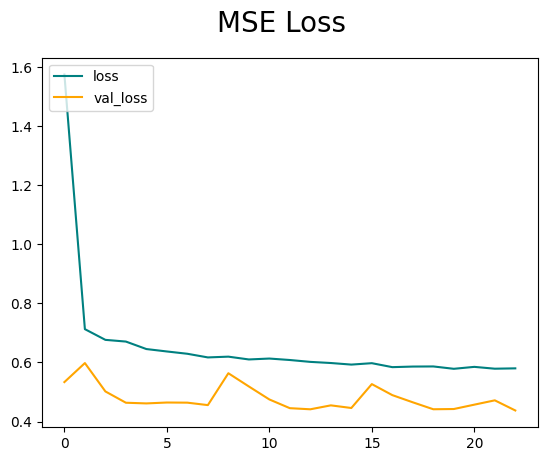

In [122]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist4.history['loss'], color='teal', label='loss')
plt.plot(hist4.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('MSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##### RMSE LOSS PLOT

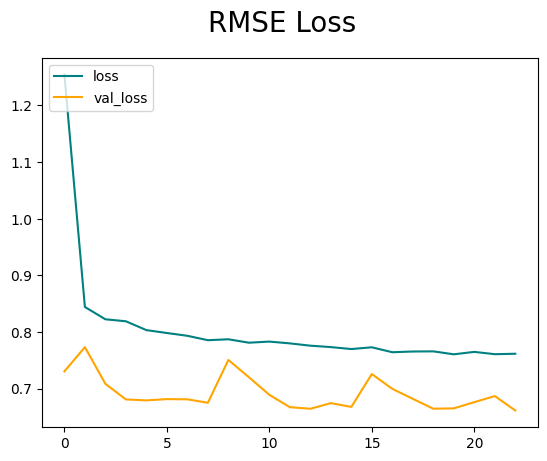

In [123]:
# plot for visualizing our model MSE train loss with validation loss
fig = plt.figure()
plt.plot(hist4.history['root_mean_squared_error'], color='teal', label='loss')
plt.plot(hist4.history['val_root_mean_squared_error'], color='orange', label='val_loss')
fig.suptitle('RMSE Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [124]:
# loading the model
model4 = load_model('models/temperature_forcast/model4/')

In [125]:
# predicting train dataset on loaded model
train_predictions4 = model4.predict(X_train4).flatten()
# storing predicted and actual in a dataframe
train_results4 = pd.DataFrame(data={'Train Predictions':train_predictions4, 'Actuals':y_train4})
train_results4.head()

1875/1875 [==============================] - 2s 796us/step


,Train Predictions,Actuals
0,-4.150331,-4.80
1,-4.050691,-4.50
2,-3.748337,-4.47
3,-3.838990,-4.54
4,-4.010795,-4.44


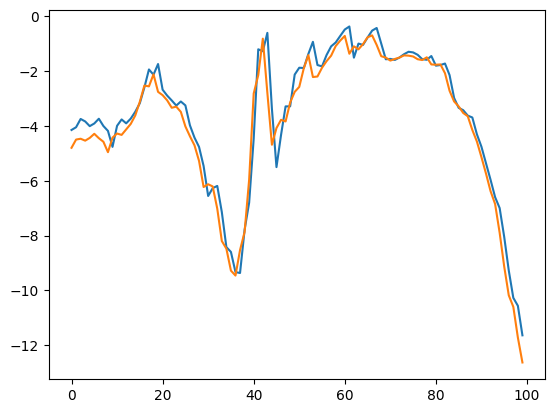

In [126]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(train_results4['Train Predictions'][:100])
plt.plot(train_results4['Actuals'][:100])

In [127]:
# predicting validation dataset on loaded model
val_predictions4 = model4.predict(X_val4).flatten()
# storing predicted and actual in a dataframe
val_results4 = pd.DataFrame(data={'Val Predictions':val_predictions4, 'Actuals':y_val4})
val_results4.head()

157/157 [==============================] - 0s 792us/step


,Val Predictions,Actuals
0,6.527363,7.50
1,7.768951,7.91
2,8.608814,7.88
3,8.289775,9.26
4,10.037635,10.38


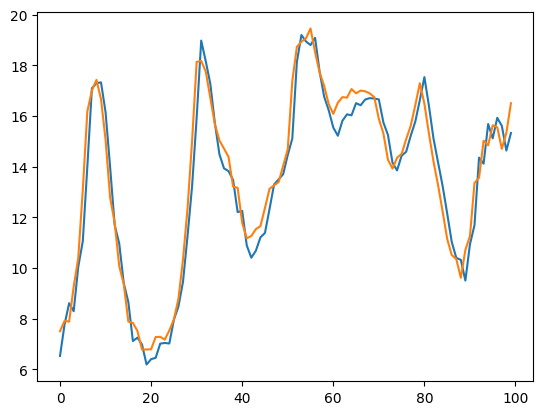

In [128]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(val_results4['Val Predictions'][:100])
plt.plot(val_results4['Actuals'][:100])

In [129]:
# predicting validation dataset on loaded model
test_predictions4 = model4.predict(X_test4).flatten()
# storing predicted and actual in a dataframe
test_results4 = pd.DataFrame(data={'Test Predictions':test_predictions4, 'Actuals':y_test4})
test_results4.head()

159/159 [==============================] - 0s 818us/step


,Test Predictions,Actuals
0,24.180616,22.89
1,22.383265,22.20
2,21.308413,21.76
3,20.675472,20.55
4,19.228342,19.31


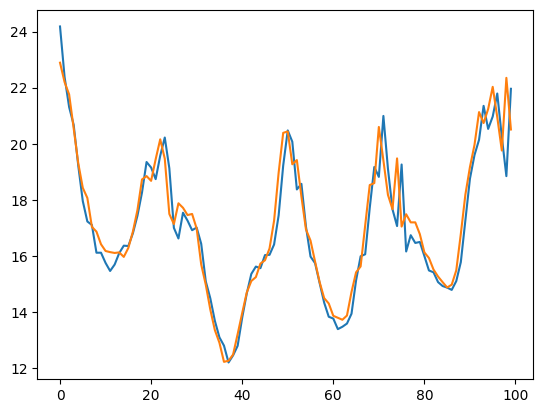

In [130]:
# plotting the predicted vs actual for visualizing how good the results are
plt.plot(test_results4['Test Predictions'][:100])
plt.plot(test_results4['Actuals'][:100])